# Part 4

## Correct batch effect

Scgen batch correction.

- **INPUT:**
    -  ```counts_norm.mtx``` 
    -  ```anno_cells_norm.txt``` 
    -  ```anno_samples_norm.txt``` 
    -  ```anno_genes_norm.txt``` 
    -  ```cell_relabelling.csv``` file containing unified cell type annotations. Stored in additional_input_files sub-directory.
    
    
- **OUTPUT:**

    -  ```counts_corr.csv.gz``` 
    -  ```anno_cells_corr.txt``` 
    -  ```anno_samples_corr.txt``` 
    -  ```anno_genes_corr.txt``` 
    -  ```adata_afterCorrection.h5ad```

### load data

In [1]:
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import numba as nb

In [2]:
# read in count table and create an adata object
adata_beforeCorrection = sc.read_mtx("counts_norm.mtx",'float64').T

In [3]:
# read in cell annotation file
anno_cells = pd.read_csv("anno_cells_norm.txt", sep = "\t") 

/tmp/ipykernel_30872/436951784.py:2: DtypeWarning: Columns (21,25,26,27,28,29,31,32,33,34,35,36,37,40,41,42,43,46,47,49,54,56,57,60,64,66,67,69) have mixed types. Specify dtype option on import or set low_memory=False.
  anno_cells = pd.read_csv("anno_cells_norm.txt", sep = "\t")


In [4]:
# read in sample annotation file
anno_samples = pd.read_csv("anno_samples_norm.txt", sep = "\t") 

In [5]:
# read in gene annotation file
anno_genes = pd.read_csv("anno_genes_norm.txt", sep = "\t") 

In [6]:
# load cell subtype and color keys
cell_relabel=pd.read_csv("additional_input_files/cell_relabelling.csv"
                        ,sep=';')

### process data

In [7]:
adata_beforeCorrection.var_names=anno_genes['gene_symbol']
print("adata_beforeCorrection.var_names[1:10]")
print(adata_beforeCorrection.var_names[1:10])
adata_beforeCorrection.var = anno_genes
adata_beforeCorrection.var.index = adata_beforeCorrection.var.index.astype(str)

adata_beforeCorrection.var_names[1:10]
Index(['LINC01409', 'LINC01128', 'LINC00115', 'FAM41C', 'AL645608.2', 'NOC2L',
       'KLHL17', 'PLEKHN1', 'HES4'],
      dtype='object', name='gene_symbol')


In [8]:
adata_beforeCorrection.obs_names=anno_cells['cell_ID']
print("adata_beforeCorrection.obs_names[1:10]")
print(adata_beforeCorrection.obs_names[1:10])
adata_beforeCorrection.obs = anno_cells
adata_beforeCorrection.obs.index = adata_beforeCorrection.obs.index.astype(str)

adata_beforeCorrection.obs_names[1:10]
Index(['2020.09.15.AML0024.CATCAAGTCCGAGAAG',
       '2020.09.15.AML0024.CATCCACAGGGACCAT',
       '2020.09.15.AML0024.CCTCAACAGAGCAAGA',
       '2020.09.15.AML0024.CCTCAACAGTTCCATG',
       '2020.09.15.AML0024.CCTCAACGTAGAATAC',
       '2020.09.15.AML0024.CCTCAACGTTCTCCCA',
       '2020.09.15.AML0024.CCTCAACTCCGAACGC',
       '2020.09.15.AML0024.CCTCAACTCTAGTCAG',
       '2020.09.15.AML0024.CCTCACAAGACAGTCG'],
      dtype='object', name='cell_ID')


In [9]:
adata_beforeCorrection

AnnData object with n_obs × n_vars = 46702 × 15770
    obs: 'sample_ID', 'cell', 'UMAP_1', 'UMAP_2', 'orig.ident', 'samples', 'Broad_cell_identity', 'Cell_type_identity', 'clusters_res.2', 'CNV_pos', 'malignant', 'aml', 'ap_aml_age', 'age_group', 'sex.x', 'inflammation_group', 'occupancy_score', 'GSM', 'date', 'cell_ID', 'cell_type_original', 'Sample.ID', 'sex.y', 'Age', 'Sequencing', 'Institution', 'Manuscript.ID', 'Dx', 'DxELN_Cytogenetic', 'Cytogenetics', 'Overall.survival', 'Flow.report.summary', 'RAS.pathway', 'NPM1', 'IDH', 'TET2', 'TP53', 'RUNX1', 'CBF', 'MLL.rearranged', 'IDH1', 'IDH2', 'ASXL1', 'BCOR', 'CBL', 'CEBPAdm', 'CSF3R', 'DNMT3A', 'ETV6', 'FLT3.TKD', 'FLT3.ITD', 'GATA2', 'JAK2', 'KIT', 'NPM1.1', 'NRAS', 'KRAS', 'PTPN11', 'PHF6', 'RAD21', 'RUNX1.1', 'SETBP1', 'SMC1A', 'STAG2', 'SRSF2', 'SF3B1', 'TET2.1', 'U2AF1', 'WT1', 'TP53.1', 'ZRSR2', 'health_status', 'case_or_control', 'cell_type', 'cell_subtype', 'total_counts_raw', 'mito_counts', 'frac_mito', 'nr_genes', 'counts_

### prepare for the visualization

In [10]:
# define colors
colors_cell_type=dict(zip(cell_relabel["cell_type"],cell_relabel["cell_type_color_hex"]))
print(colors_cell_type)

{'B': '#4FC384', 'Mono': '#F09040', 'T': '#4F92EE', 'DC': '#854701', 'Ery': '#F72E3A', 'Megakaryocytes': '#C89B7A', 'NK': '#4F64EE', 'HSPC': '#D040F0', 'Gran': '#CD6600', 'PeriVasc': '#BEBEBE', 'LymP': '#556B2F'}


In [11]:
#there is an error at line 9, cell_subtype is only 2 values?
adata_beforeCorrection.obs["cell_subtype"].value_counts()

Mono      18004
CD8_T      6272
CD4_T      4989
B          4413
HSPC       3169
NK         3078
Gran       2332
Ery        1674
cDC        1092
pDC         542
gd_T        487
Plasma      352
MAIT        298
Name: cell_subtype, dtype: int64

In [12]:
# rename "malignangt" columns into "bares_mutatoin"
adata_beforeCorrection.obs["bares_mutation"] = adata_beforeCorrection.obs["malignant"].astype('str')

In [13]:
# define color schemes
colors_cell_subtype=dict(zip(cell_relabel["cell_subtype"],cell_relabel["cell_subtype_color_hex"]))
print(colors_cell_subtype)

colors_cell_type=dict(zip(cell_relabel["cell_type"],cell_relabel["cell_type_color_hex"]))
print(colors_cell_type)

{'B': '#4FC384', 'Mono': '#F09040', 'pro_Mono': '#F0AD40', 'CD4_T': '#4FCCEE', 'CD8_T': '#4F92EE', 'pDC': '#854701', 'cDC': '#B95D10', 'early_Ery': '#F72E3A', 'late_Ery': '#C72D37', 'Megakaryocytes': '#C89B7A', 'NK': '#4F64EE', 'Plasma': '#317E54', 'HSPC': '#D040F0', 'MAIT': '#00688B', 'Gran': '#CD6600', 'gd_T': '#00BFFF', 'PeriVasc': '#BEBEBE', 'LymP': '#556B2F', 'Ery': '#C72D37'}
{'B': '#4FC384', 'Mono': '#F09040', 'T': '#4F92EE', 'DC': '#854701', 'Ery': '#F72E3A', 'Megakaryocytes': '#C89B7A', 'NK': '#4F64EE', 'HSPC': '#D040F0', 'Gran': '#CD6600', 'PeriVasc': '#BEBEBE', 'LymP': '#556B2F'}


In [14]:
adata_beforeCorrection.uns["health_status_colors"] = ["#7C001F" # bordeau for AML
                                                     , "#7ac5cd" # CadetBlue3 for healthy
                                                     ]

adata_beforeCorrection.uns["bares_mutation_colors"] = ["#A6ACAF" # grey for FALSE
                                                  , "#C0392B" # red for TRUE
                                                 ]

### visualize before batch correction

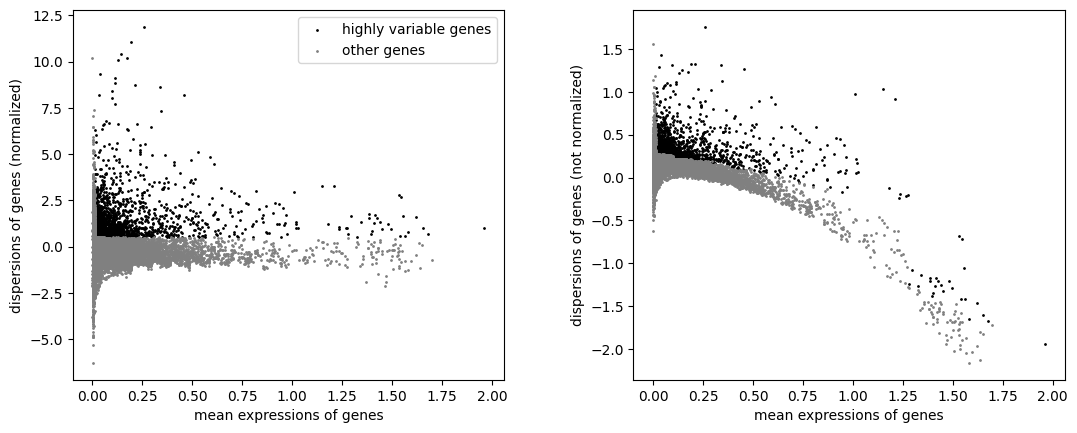

In [15]:
# logtransform before HVG calculation
sc.pp.log1p(adata_beforeCorrection)

sc.pp.highly_variable_genes(adata_beforeCorrection)
sc.pl.highly_variable_genes(adata_beforeCorrection)

In [16]:
# print how many HVGs we have:
print("Nr of HVGs:")
print(sum(adata_beforeCorrection.var.highly_variable))

Nr of HVGs:
1933


In [17]:
sc.tl.pca(adata_beforeCorrection, svd_solver='arpack')

/home/mcelik/miniconda3/envs/joint/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


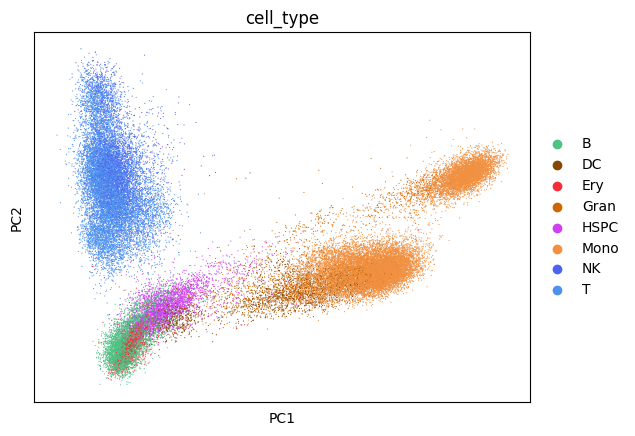

In [18]:
sc.pl.pca(adata_beforeCorrection
          , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_beforeCorrection_cell_type.pdf"
         )

In [19]:
sc.pp.neighbors(adata_beforeCorrection)

2023-02-23 15:38:38.369577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 15:38:38.642697: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 15:38:38.642733: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-23 15:38:40.682365: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [20]:
sc.tl.umap(adata_beforeCorrection)

/home/mcelik/miniconda3/envs/joint/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


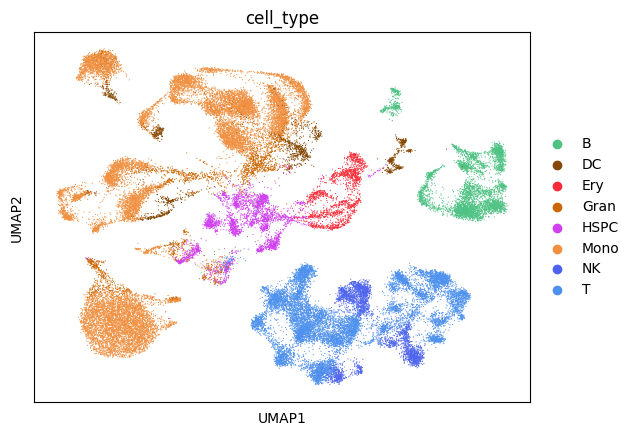

In [21]:
sc.pl.umap(adata_beforeCorrection
           , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_beforeCorrection_cell_type.pdf"
          )

/home/mcelik/miniconda3/envs/joint/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


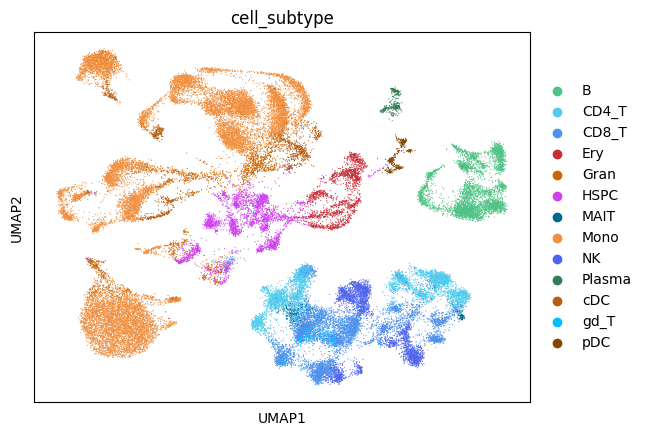

In [22]:
sc.pl.umap(adata_beforeCorrection
           , color=["cell_subtype"]
          ,palette=colors_cell_subtype
          ,save="_beforeCorrection_cell_subtype.pdf"
          )

/home/mcelik/miniconda3/envs/joint/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


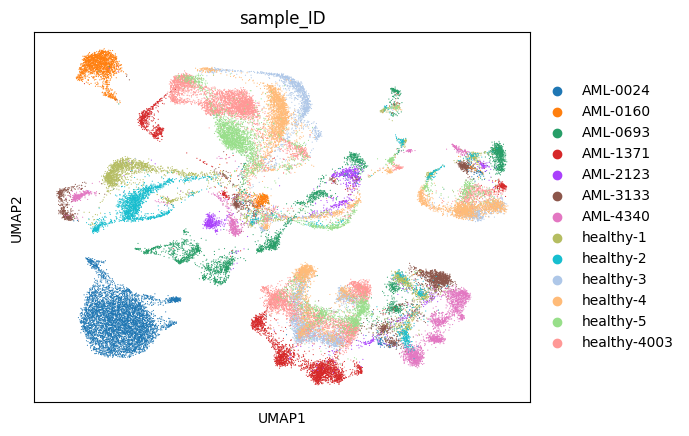

In [23]:
sc.pl.umap(adata_beforeCorrection
           , color=["sample_ID"]
          ,save="_beforeCorrection_sample_ID.pdf"
          )

/home/mcelik/miniconda3/envs/joint/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


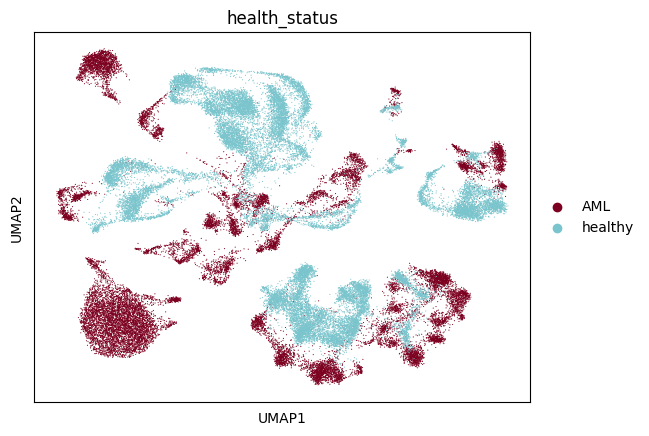

In [24]:
sc.pl.umap(adata_beforeCorrection
           , color=["health_status"]
          ,save="_beforeCorrection_health_status.pdf"
          )

/home/mcelik/miniconda3/envs/joint/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


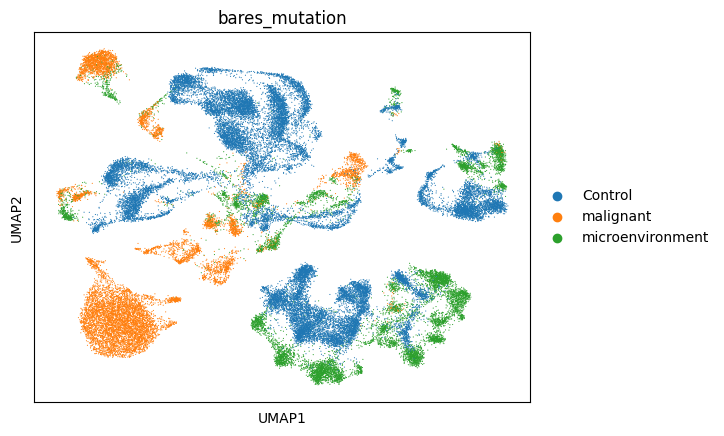

In [25]:
sc.pl.umap(adata_beforeCorrection
           , color=["bares_mutation"]
          ,save="_beforeCorrection_malignant.pdf"
          )

/home/mcelik/miniconda3/envs/joint/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


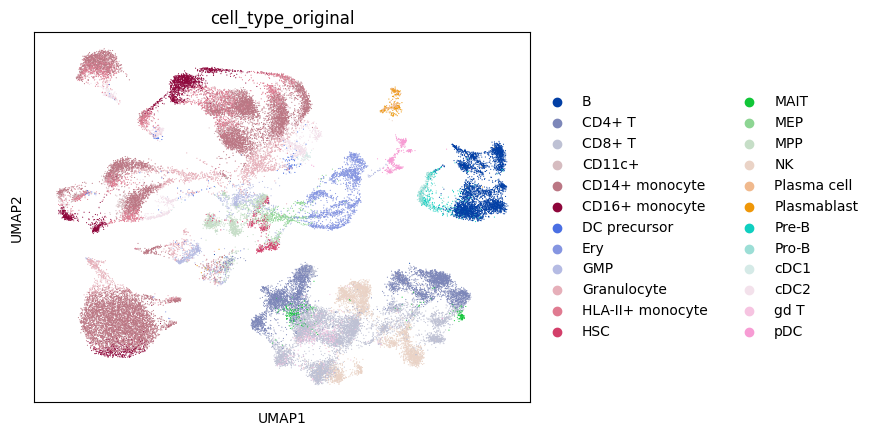

In [26]:
sc.pl.umap(adata_beforeCorrection
           , color=["cell_type_original"]
          ,save="_beforeCorrection_cell_type_original.pdf"
          )

/home/mcelik/miniconda3/envs/joint/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mcelik/miniconda3/envs/joint/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


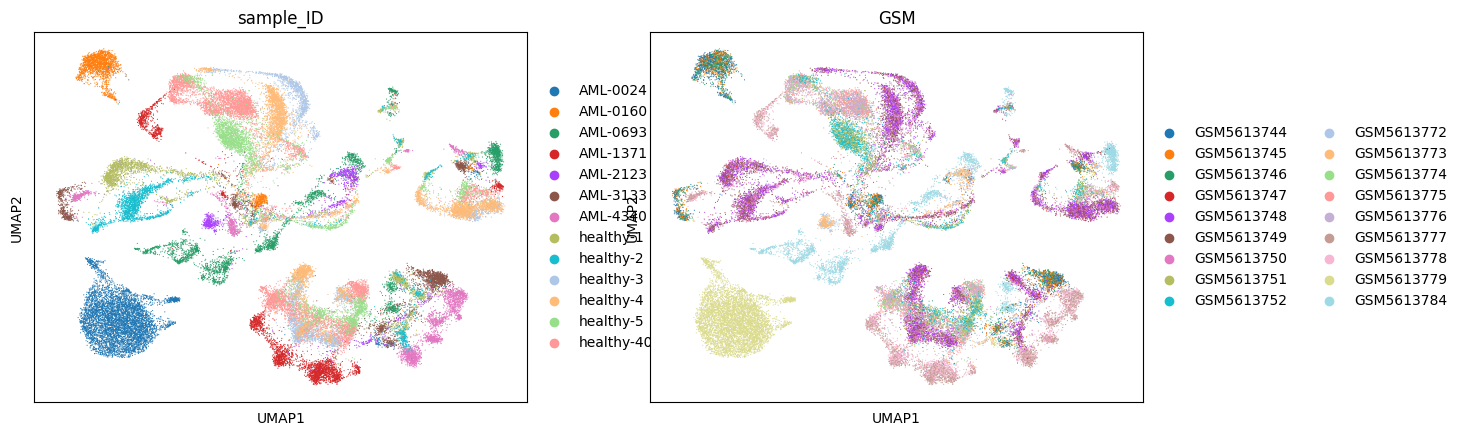

In [27]:
sc.pl.umap(adata_beforeCorrection
           , color=["sample_ID","GSM"]
          ,save="_beforeCorrection_GSM.pdf"
          )

/home/mcelik/miniconda3/envs/joint/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mcelik/miniconda3/envs/joint/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


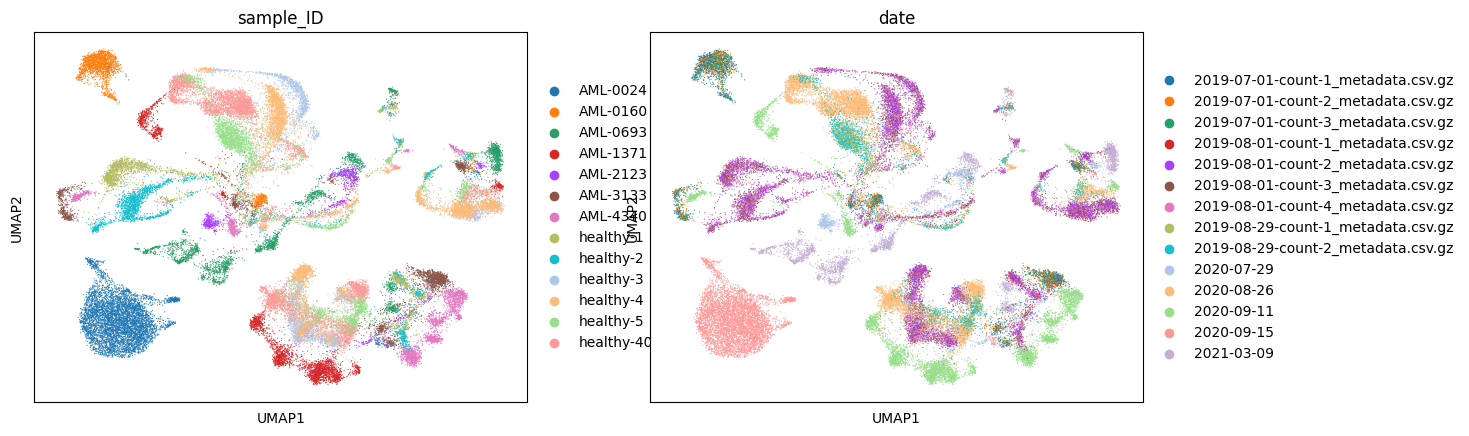

In [28]:
sc.pl.umap(adata_beforeCorrection
           , color=["sample_ID","date"]
          ,save="_beforeCorrection_date.pdf"
          )

# Export

In [44]:
# export counts as csv.gz
print("save counts_corr.csv.gz")

counts_corr=adata_beforeCorrection.to_df().transpose()
counts_corr.index = adata_beforeCorrection.var.gene_symbol
counts_corr.columns = adata_beforeCorrection.obs.cell
counts_corr.to_csv("counts_corr.csv.gz"
                   ,index=True
                   ,compression="gzip"
                   )

save counts_corr.csv.gz


In [45]:
# export anno_cells_corr
print("save anno_cells_corr.txt")
adata_beforeCorrection.obs.to_csv("anno_cells_corr.txt"
                    ,sep = "\t"
                    ,index = True)


save anno_cells_corr.txt


In [46]:
# export anno_samples_corr
print("save anno_samples_corr.txt")
anno_samples.to_csv("anno_samples_corr.txt"
                    ,sep = "\t"
                    ,index = True)

save anno_samples_corr.txt


In [47]:
# export anno_genes_corr
print("save anno_genes_corr.txt")
adata_beforeCorrection.var.to_csv("anno_genes_corr.txt"
                    ,sep = "\t"
                    ,index = True)

save anno_genes_corr.txt
